# PCA

## Realizado por: Pablo Sánchez Cabrera

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_kmo
from statsmodels.multivariate import pca
import matplotlib.pyplot as plt
import seaborn as sns

Se cargan los datos de `Seatbelts`. Estos datos están ya disponibles en la librería **statsmodels**.

In [6]:
Seatbelts = sm.datasets.get_rdataset("Seatbelts", "datasets", cache=True).data
Seatbelts = Seatbelts.drop(['law'], axis=1) # se borra la variable "law"

# Breve información sobre el data.frame
print(f"Columnas y filas: {Seatbelts.shape}")
Seatbelts.describe() # Info estadística-descriptiva

Columnas y filas: (192, 7)


,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,122.802083,1670.307292,837.218750,401.208333,14993.604167,0.103624,9.057292
std,25.379886,289.610958,175.098967,83.102210,2938.049207,0.012176,3.636903
min,60.000000,1057.000000,426.000000,224.000000,7685.000000,0.081179,2.000000
25%,104.750000,1461.750000,715.500000,344.750000,12685.000000,0.092577,6.000000
50%,118.500000,1631.000000,828.500000,401.500000,14987.000000,0.104477,8.000000
75%,138.000000,1850.750000,950.750000,456.250000,17202.500000,0.114056,12.000000
max,198.000000,2654.000000,1299.000000,646.000000,21626.000000,0.133027,17.000000


Se obtiene la matriz de correlaciones

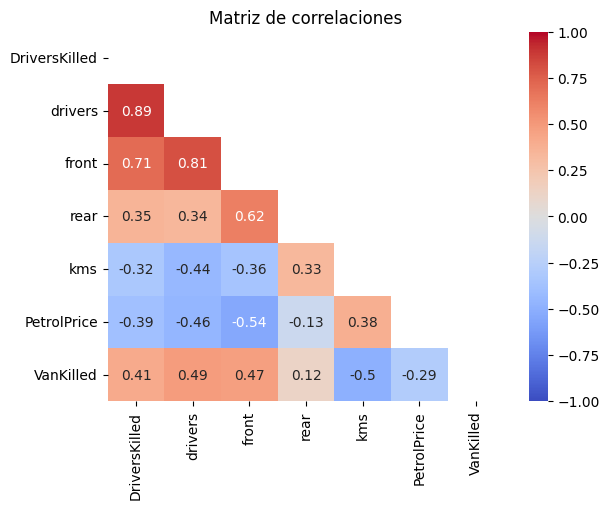

In [7]:
matriz_cor = Seatbelts.corr('pearson')  # correlación de pearson

# como cor(x,x)=1 y cor(x,y)=cor(y,x) se puede disponer solo de la diagonal inferior. 

mask = np.zeros(matriz_cor.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(matriz_cor, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', mask=mask) 
# cmap para elegir la gama de colores y vmin y vmax identificar todo el espectro de valores de la correlación de pearson [-1,1]
plt.title('Matriz de correlaciones')
plt.show()

Se realiza un análisis de Utilidad de Reducción de dimensión` usando el `índice KMO`

In [8]:
# Análisis Utilidad Reducción de Dimensión - Índice KMO
kmo_total = calculate_kmo(Seatbelts)[1]
kmo_var = calculate_kmo(Seatbelts)[0]
print('KMO_Total:', round(kmo_total,3))
print('KMO_variable:', kmo_var)

KMO_Total: 0.669
KMO_variable: [0.75338326 0.72294629 0.65795087 0.40214211 0.53516876 0.83412899
 0.88197069]


A la vista de los resultados del KMO (variable) deben eliminarse del análisis las variables `rear` y `kms`.
Se observó en la matriz de correlaciones que `rear` y `kms` tenían una correlación lineal baja.

`Importante`: se incluyen después del tratamiento de reducción de datos.

Una vez se han excluido estas dos variables se vuelve a realizar el análisis:

In [11]:
# Data final a aplicar técnicas de reducción
var_borrar = ['rear', 'kms']
data_red = Seatbelts.drop(columns=var_borrar)

#Índice KMO
kmo_total=calculate_kmo(data_red)[1]
kmo_var=calculate_kmo(data_red)[0]
print('KMO_Total:', round(kmo_total,3))
print('KMO_variable:', kmo_var)

KMO_Total: 0.776
KMO_variable: [0.73391308 0.69426983 0.83038908 0.87610158 0.9330939 ]


Puede verse que el `índice KMO` ha aumentado al eliminarse las variables menos correlacionadas

## Análisis de Componentes Principales

Se realiza un PCA con los datos `estandarizados` y se usa el `Scree Plot` para analizar cómo explican la varianza de los datos cada una de las componentes

In [18]:
comp_prin=pca.PCA(data_red, standardize=True) # Variables estandarizadas

Tanto el gráfico de las componentes como la varianza explicada por las mismas se obtiene empleando los métodos:
- `rsquare`: indica el porcentaje de varianza acumulada por cada componente
- `plot_scree`: permite visualizar la importancia de cada componente

También podemos ver los autovalores de cada componente con `eigenvals`

In [26]:
comp_prin.eigenvals

0    623.543907
1    138.165364
2    129.817049
3     51.052051
4     17.421630
Name: eigenvals, dtype: float64

Analizamos cuántas componentes vamos a tener en cuenta en nuestro análisis:

In [24]:
comp_prin.rsquare # no tener en cuenta el valor 0 en este caso (solo en eset caso)

ncomp
0    0.000000
1    0.649525
2    0.793447
3    0.928673
4    0.981852
5    1.000000
Name: rsquare, dtype: float64

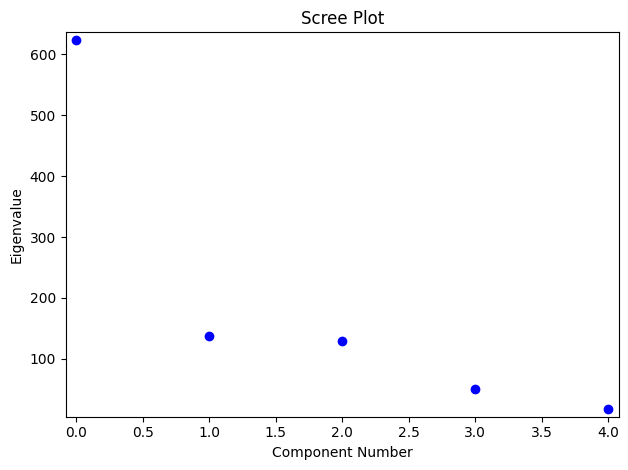

In [21]:
# ScreePlot -> obtención del número de componentes
comp_prin.plot_scree(ncomp=data_red.shape[1], log_scale=False, cumulative=False) #n_componentes=5 
plt.show()

Se escogen 3 componentes ya que explican más del 90% de la variabilidad de los datos de partida

`Cargas de las componentes principales sobre las variables antiguas`

In [22]:
comp_prin.loadings 

,comp_0,comp_1,comp_2,comp_3,comp_4
DriversKilled,0.485753,-0.142211,0.434500,0.484635,0.565825
drivers,0.518634,-0.108084,0.294747,0.104632,-0.788361
front,0.497643,0.078728,0.081918,-0.826452,0.237527
PetrolPrice,-0.353479,-0.802029,0.412172,-0.248825,-0.001507
VanKilled,0.349953,-0.564487,-0.740093,0.096141,0.043671


De estos datos se puede concluir que:
- La Componente 1 está relacionada con todas las variables de forma bastante "equitativa"
- La Componente 2 está altamente relacionada con "PetrolPrice"
- La Componente 3 está fuertemente relacionada con "VanKilled"

`Puntuaciones - Componentes elegidas`

In [28]:
componentes = ['comp_0', 'comp_1', 'comp_2']
scores_3comp = comp_prin.scores.loc[:, componentes]

scores_3comp.head(10)

,comp_0,comp_1,comp_2
0,0.004585,-0.027131,-0.075723
1,-0.043235,0.064591,-0.002919
2,-0.018101,-0.016242,-0.104595
3,-0.051555,0.054756,-0.069704
4,0.018550,0.011086,-0.027467
5,0.006712,-0.017866,-0.114808
6,0.008521,-0.010504,-0.056730
7,0.000811,0.056980,0.037620
8,-0.001459,0.001768,-0.043445
9,0.036339,-0.092868,-0.110257


`Interpretación de los resultados en un Biplot`

Se presenta un gráfico `biplot` para interpretar los los individuos y las variables de las 2 primeras componentes.

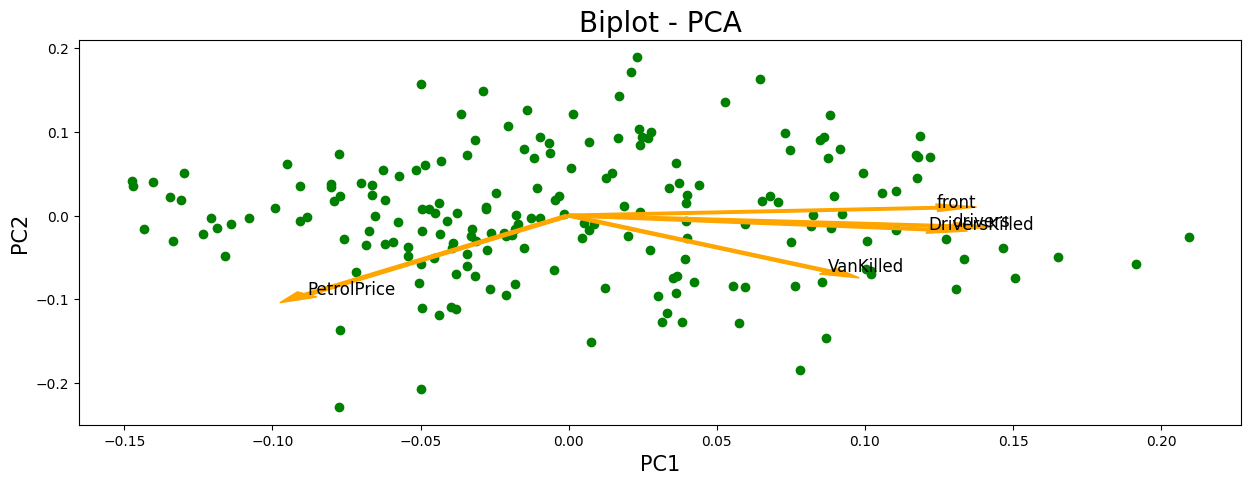

In [29]:
score_xy = comp_prin.scores.loc[:, ['comp_0', 'comp_1']] # puntuaciones de los individuos en las 2 componentes principales
xy = comp_prin.coeff.iloc[[0,1], :]  # coordenadas de las nuevas variables en función de las antiguas
n = xy.shape[1] 
lista = xy.columns
factor = 0.01 # factor para mejor visualización de los autovalores (a elegir por usuario)

# gráfico biplot
plt.figure(figsize=(15,5))
plt.scatter(score_xy['comp_0'], score_xy['comp_1'], color='green') # coordenadas de los individuos
for i in range(n):  # coordenadas de las variables
    plt.arrow(0, 0, xy.iloc[0, i]*factor, xy.iloc[1, i]*factor, color='orange', width=0.003)
    plt.text(xy.iloc[0, i]*factor, xy.iloc[1, i]*factor, lista[i], fontsize=12)

plt.title('Biplot - PCA',  fontsize=20), plt.xlabel('PC1',  fontsize=15), plt.ylabel('PC2',  fontsize=15)
plt.show()